In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torchmetrics
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image
from collections import defaultdict

In [41]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [42]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v2/'
dataset = CustomImageDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

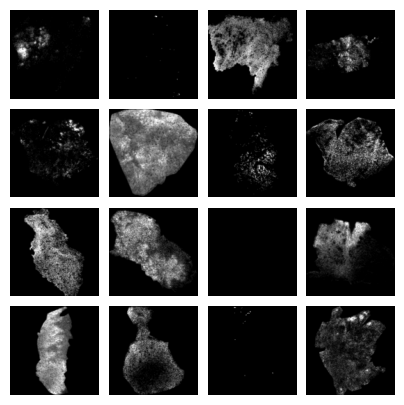

In [43]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [45]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [50]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 20
epochs = 20
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cpu")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/20, Loss: 66065.8554, Time: 23.41 sec
Epoch 2/20, Loss: 46792.7873, Time: 23.37 sec
Epoch 3/20, Loss: 44496.4554, Time: 23.92 sec
Epoch 4/20, Loss: 43372.5127, Time: 22.14 sec
Epoch 5/20, Loss: 42752.2485, Time: 23.19 sec
Epoch 6/20, Loss: 42358.3068, Time: 25.36 sec
Epoch 7/20, Loss: 42059.5690, Time: 29.86 sec
Epoch 8/20, Loss: 41778.5280, Time: 30.57 sec
Epoch 9/20, Loss: 41613.8598, Time: 28.27 sec
Epoch 10/20, Loss: 41496.2081, Time: 28.96 sec
Epoch 11/20, Loss: 41331.8246, Time: 29.87 sec
Epoch 12/20, Loss: 41254.9294, Time: 27.87 sec
Epoch 13/20, Loss: 41148.9084, Time: 27.20 sec
Epoch 14/20, Loss: 41094.8919, Time: 28.87 sec
Epoch 15/20, Loss: 40998.9648, Time: 26.58 sec
Epoch 16/20, Loss: 40944.3461, Time: 27.65 sec
Epoch 17/20, Loss: 40887.3199, Time: 29.73 sec
Epoch 18/20, Loss: 40820.2683, Time: 27.93 sec
Epoch 19/20, Loss: 40766.8536, Time: 27.01 sec
Epoch 20/20, Loss: 40718.3098, Time: 28.04 sec


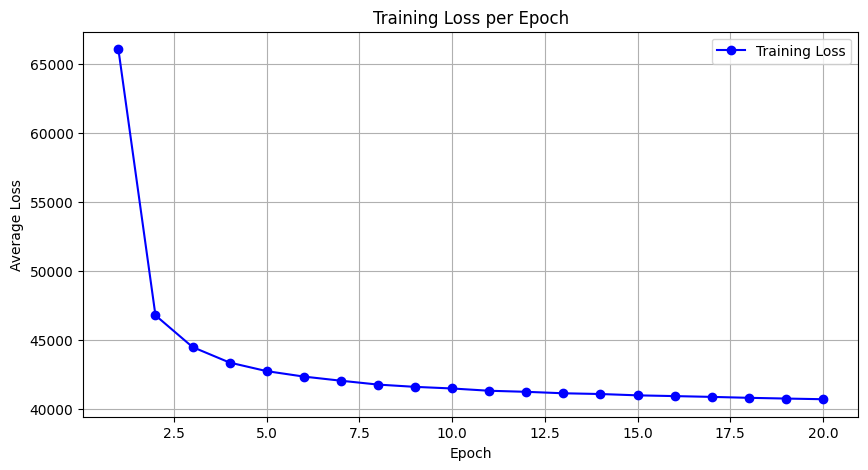

In [51]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

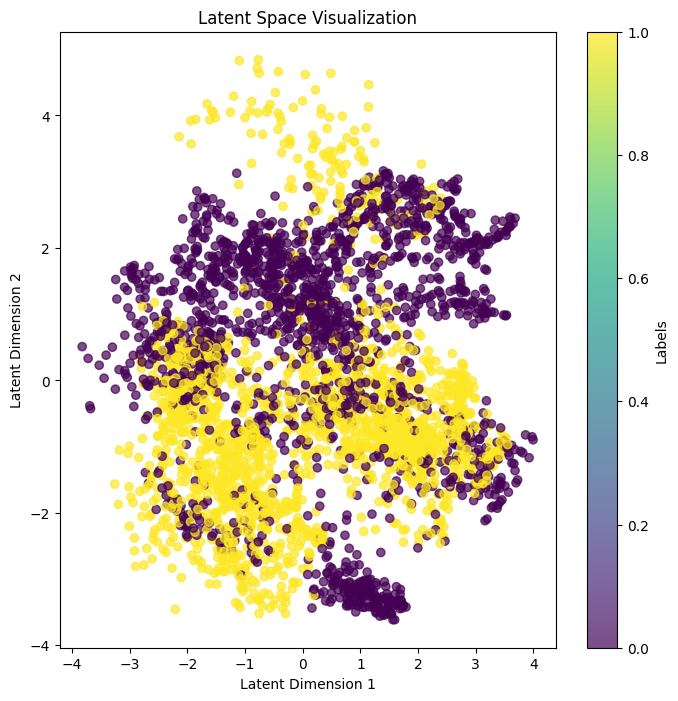

In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, dataloader, latent_dim=20, use_tsne=False)


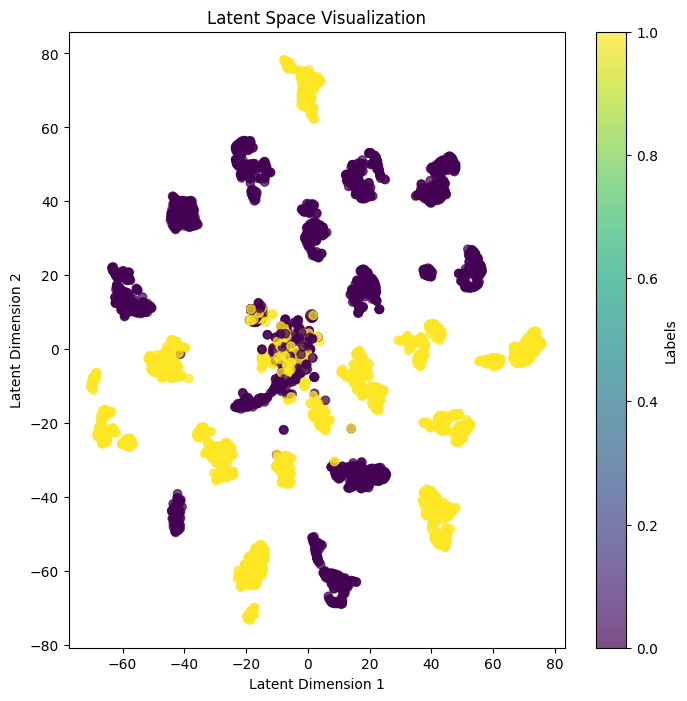

In [53]:
visualize_latent_space(model, dataloader, latent_dim=20, use_tsne=True)

In [54]:
import torch.nn as nn
def extract_latent_features(model, dataloader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use mu as the latent representation
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents)
    labels = torch.cat(labels)
    return latents, labels

latent_vectors, target_labels = extract_latent_features(model, dataloader)


In [56]:
latent_features_np = latent_vectors.cpu().numpy()  # Move to CPU and convert to NumPy
target_labels_np = target_labels.cpu().numpy()
np.save("latent_features.npy", latent_features_np)
np.save("target_labels.npy", target_labels_np)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

latent_features = np.load("latent_features.npy")
labels = np.load("target_labels.npy") 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.25, random_state=42)

# Train a classifier on the latent features
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 92.77%


In [ ]:
import os
from PIL import Image
import torch
import zarr
import numpy as np
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
                 'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
                 'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N',
             'SQ1634_s1_N', 'SQ1634_s2_R', 'SQ1634_s3_R', 'SQ1634_s4_N',
             'SQ1635_s1_N', 'SQ1635_s2_R', 'SQ1635_s3_R', 'SQ1635_s4_N',
             'SQ1636_s1_R', 'SQ1636_s2_N', 'SQ1636_s3_N', 'SQ1636_s4_R']

tile_ls = []
label_ls = []

folder_path = '/home/mass_spec_img/mass_spec_img/data/zarr'
for sample in sample_ls:
    zarr_path = f'{folder_path}/{sample}/slide.zarr'
    slide = zarr.open(zarr_path, mode='r')
    print(f'Zarr dataset loaded from {zarr_path}')
    tile_ls.append(slide)
    if sample.startswith("SQ1631"):
        if "s1" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1632"):
        if "s4" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1633"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(2)
    elif sample.startswith("SQ1634"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1635"):
        if "s3" in sample or "s4" in sample:
            label_ls.append(2)
        elif "s1" in sample:
            label_ls.append(1)
        else:
            label_ls.append(0)
    else:
        if "s4" in sample:
            label_ls.append(1)
        else:
            label_ls.append(2)

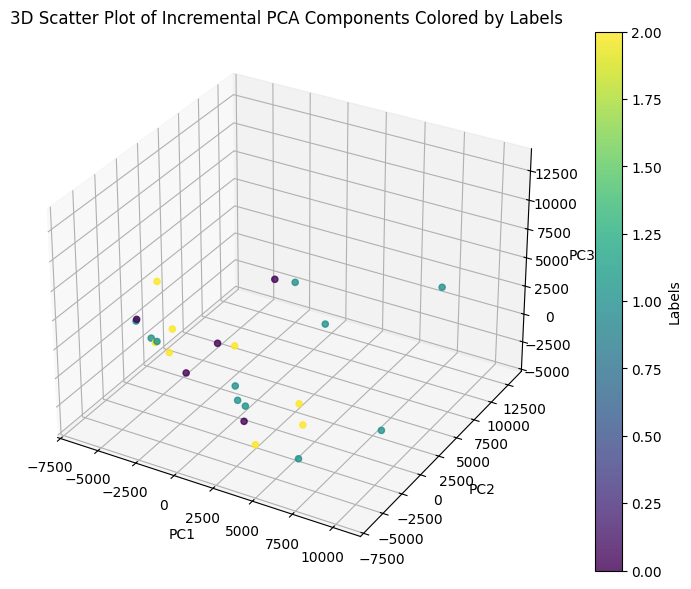

In [48]:
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt


mean_data = tile_ls.mean(axis=1)  # shape: (24, 500, 500)

reshaped_data = mean_data.reshape(24, -1)  # reshaped: (24, 250000)

n_components = 3
batch_size = 5 
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
pca_result = ipca.fit_transform(reshaped_data)  # Shape: (24, 3)

# Step 4: 3D Scatter Plot with color based on labels
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                c=label_ls, cmap='viridis', alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(sc, ax=ax, label="Labels")
plt.title("3D Scatter Plot of Incremental PCA Components Colored by Labels")
plt.show()


In [61]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (500 // 8) * (500 // 8), 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(torch.unique(labels)))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (500 // 8) * (500 // 8))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

Epoch 1/20, Train Loss: 2.9525, Val Loss: 10509.1582, Accuracy: 20.00%
Epoch 2/20, Train Loss: 5814.2954, Val Loss: 4498.7178, Accuracy: 20.00%
Epoch 3/20, Train Loss: 4357.8770, Val Loss: 489.2145, Accuracy: 60.00%
Epoch 4/20, Train Loss: 845.0521, Val Loss: 135.1507, Accuracy: 20.00%
Epoch 5/20, Train Loss: 114.5011, Val Loss: 31.3444, Accuracy: 20.00%
Epoch 6/20, Train Loss: 15.1890, Val Loss: 22.6839, Accuracy: 0.00%
Epoch 7/20, Train Loss: 23.8764, Val Loss: 14.8079, Accuracy: 60.00%
Epoch 8/20, Train Loss: 5.4808, Val Loss: 7.4113, Accuracy: 20.00%
Epoch 9/20, Train Loss: 0.4385, Val Loss: 9.1816, Accuracy: 0.00%
Epoch 10/20, Train Loss: 1.2753, Val Loss: 6.6015, Accuracy: 20.00%
Epoch 11/20, Train Loss: 1.0401, Val Loss: 3.8277, Accuracy: 20.00%
Epoch 12/20, Train Loss: 0.1366, Val Loss: 1.9972, Accuracy: 40.00%
Epoch 13/20, Train Loss: 0.0903, Val Loss: 1.8701, Accuracy: 20.00%
Epoch 14/20, Train Loss: 0.0303, Val Loss: 1.8264, Accuracy: 40.00%
Epoch 15/20, Train Loss: 0.0045, 

In [37]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [39]:
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 3 # number of classes in the output
model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from tqdm.notebook import tqdm
import torch

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


In [64]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

In [65]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)

Epoch 1/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Accuracy: 0.9992


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0014, Test Accuracy: 0.9994
Epoch 2/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Accuracy: 0.9997


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0007, Test Accuracy: 0.9998
Epoch 3/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0012, Test Accuracy: 0.9995
Epoch 4/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0010, Test Accuracy: 0.9995
Epoch 5/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0002, Test Accuracy: 1.0000


In [ ]:
# Dataset implementation for your specific case
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.sample_dict = defaultdict(list)
        self.labels = []
        self.samples = []


        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
            
            for img_path in full_image_path:
                img_array = self._load_image_as_numpy(img_path)
                self.sample_dict[img_path.split("/")[-1][:8]].append(img_array)
        # convert the dictionary into list so we can get the samples by indexing
        for sample in self.sample_dict:
            self.samples.append(self.sample_dict[sample])
            slide_num = sample[:6]
            tissue_num = sample[6:]
            print(slide_num, tissue_num)
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)


        

    def _load_image_as_tensor(self, path):
        """
        Load an image as a NumPy array.
        
        Args:
            path (str): Path to image file
            
        Returns:
            np.ndarray: Image as NumPy array with shape [H, W]
        """
        # Open image using PIL
        with Image.open(path) as img:
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # Convert to NumPy array
            img_np = np.array(img, dtype=np.float32)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            if self.tranform:
                img_tensor = self.transorm(img_tensor)
        return img_tensor
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        
        # Stack list of images for each tissue to form a 50-channel tensor
        sample_tensor = torch.stack(sample, dim=0)  # Shape: [50, H, W]
        
        if self.transform:
            # Note: You may need custom transforms for multi-channel data
            sample_tensor = self.transform(sample_tensor)
            
        return sample_tensor, label

In [21]:
# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v2/'
dataset = MultiChannelDataset(folder_path, transform=None)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

SQ1635 S1
SQ1635 S2
SQ1635 S3
SQ1635 S4
SQ1636 S1
SQ1636 S2
SQ1636 S3
SQ1636 S4
SQ1631 S1
SQ1631 S2
SQ1631 S3
SQ1631 S4
SQ1632 S1
SQ1632 S2
SQ1632 S3
SQ1632 S4
SQ1633 S1
SQ1633 S2
SQ1633 S3
SQ1633 S4
SQ1634 S1
SQ1634 S2
SQ1634 S3
SQ1634 S4


In [22]:
img, label = dataset[0]
print(label)

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray